### Задание

- Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.
- Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков.
- Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
- Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.
- Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)
- Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [161]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

### загрузка и предаброботка данных

In [162]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data_w = data.copy().resample('W').mean()
data_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


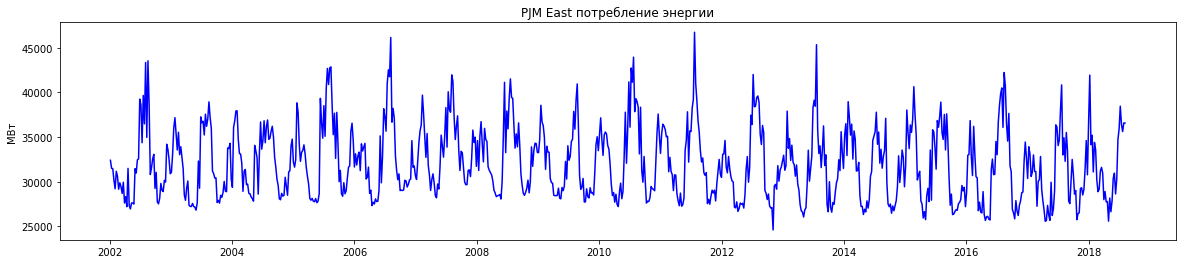

In [163]:
plt.figure(figsize =(20,4))
plt.plot( data_w.index, data_w['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [164]:
# Удалим данные, которые в недельном ресемплинге теряют актуальность. У даляем год, так как в годовом разрезе тренда нет
data_w.drop('hour', axis=1,inplace=True)
data_w.drop('dayofmonth', axis=1,inplace=True)
data_w.drop('dayofweek', axis=1,inplace=True)
data_w.drop('year', axis=1,inplace=True)
data_w.drop('is_next_holiday', axis=1,inplace=True)
data_w.drop('dayofyear', axis=1,inplace=True)

data_w.head()

,PJME_MW,month,quarter,weekofyear,is_holiday,is_prev_holiday
Date,,,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0,0.160839,0.000000
2002-01-13,31487.386905,1.000000,1.0,2.0,0.000000,0.000000
2002-01-20,31452.880952,1.000000,1.0,3.0,0.000000,0.142857
2002-01-27,30141.529762,1.000000,1.0,4.0,0.142857,0.000000
2002-02-03,29196.488095,1.428571,1.0,5.0,0.000000,0.000000


In [165]:
# Добавим несколько новым признаков
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 
import seaborn as sns

In [166]:
scl=StandardScaler()
tsne_ =TSNE(n_components=2)

X = data_w.iloc[:,:-1].values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)

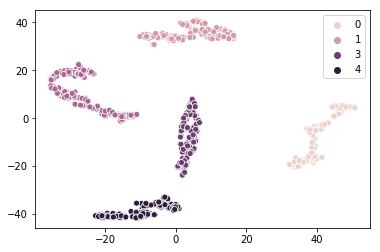

In [167]:
clast_0 = DBSCAN(eps=5, leaf_size=15 )
clast_1 = DBSCAN(eps=2, leaf_size=5)
X_clast =clast_0.fit_predict(X_t)
X_scale_clast =clast_1.fit_predict(Xscale)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

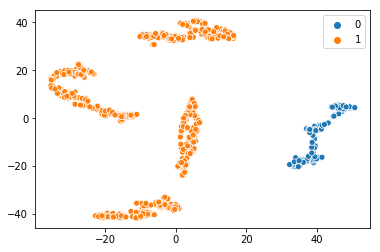

In [168]:
sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_scale_clast )
plt.show()

In [169]:
# в первом варианте признаком больше и кажется они распределены более правильно
data_w['week_month'] = X_clast
# новые признаки получились так: 0 - недели спраздниками, 1-4 кварталы
data_w.iloc[np.where(data_w['week_month']==0)[0]].iloc[:10,:]

,PJME_MW,month,quarter,weekofyear,is_holiday,is_prev_holiday,week_month
Date,,,,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0,0.160839,0.000000,0
2002-01-27,30141.529762,1.000000,1.0,4.0,0.142857,0.000000,0
2002-02-24,29144.130952,2.000000,1.0,8.0,0.142857,0.000000,0
2002-06-02,31448.660714,5.285714,2.0,22.0,0.142857,0.000000,0
2002-07-07,38626.654762,7.000000,3.0,27.0,0.142857,0.142857,0
2002-09-08,31535.172619,9.000000,3.0,36.0,0.142857,0.000000,0
2002-10-20,27504.827381,10.000000,4.0,42.0,0.142857,0.000000,0
2002-11-17,28881.886905,11.000000,4.0,46.0,0.142857,0.000000,0
2002-12-01,29946.190476,11.142857,4.0,48.0,0.142857,0.142857,0


In [170]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:])
Xpca.shape

(866, 2)

In [171]:
data_w['pca1']=Xpca[:,0]
data_w['pca2']=Xpca[:,1]
data_w.head()

,PJME_MW,month,quarter,weekofyear,is_holiday,is_prev_holiday,week_month,pca1,pca2
Date,,,,,,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0,0.160839,0.000000,0,-2.454496,2.612369
2002-01-13,31487.386905,1.000000,1.0,2.0,0.000000,0.000000,1,-2.672075,-0.244236
2002-01-20,31452.880952,1.000000,1.0,3.0,0.000000,0.142857,1,-2.633792,-0.248124
2002-01-27,30141.529762,1.000000,1.0,4.0,0.142857,0.000000,0,-2.368253,2.281766
2002-02-03,29196.488095,1.428571,1.0,5.0,0.000000,0.000000,1,-2.483988,-0.263194


Добавим к нашей модели 1-е разности. При этом следует помнить, что такие операции уменьшают общую длину корректной выборки на 1, т.е. первую строку данных следует исключить из модели в момент обучения.
добавим логарифмические признаки

In [172]:
first_diff =np.array(data_w.iloc[1:,0].values - data_w.iloc[:-1,0].values).astype('float32') 
data_w['diff1'] = 0
data_w['diff1'] =  data_w['diff1'].astype('float') 
data_w['diff1'].values[1:] = first_diff

In [173]:
first_diff_w =(first_diff) / data_w.iloc[1:,0].values
data_w['diff1_w'] = 0
data_w['diff1_w'] =  data_w['diff1_w'].astype('float') 
data_w['diff1_w'].values[1:] = np.array(first_diff_w).astype('float32')

In [174]:
first_diff_l =np.log(data_w.iloc[1:,0].values) 
data_w['diff1_l'] = 0
data_w['diff1_l'] =  data_w['diff1_l'].astype('float') 
data_w['diff1_l'].values[1:] = first_diff_l

In [175]:
# Добавим скользящее среднее по всей модели с глубиной 4 недели. Размер окна определен длиной месячных циклов.
data_w['w_m4']=data_w['PJME_MW'].rolling(window=4).mean()

In [176]:
# добавим еще и экспонентциальную среднюю
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

data_w['exp_0_05'] = exponential_smoothing(data_w['PJME_MW'], 0.05)

In [177]:
# В средней скользящей появились пропуски в первых трех строках. Пока оставим.
data_w.head()

,PJME_MW,month,quarter,weekofyear,is_holiday,is_prev_holiday,week_month,pca1,pca2,diff1,diff1_w,diff1_l,w_m4,exp_0_05
Date,,,,,,,,,,,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0,0.160839,0.000000,0,-2.454496,2.612369,0.000000,0.000000,0.000000,NaN,32392.160839
2002-01-13,31487.386905,1.000000,1.0,2.0,0.000000,0.000000,1,-2.672075,-0.244236,-904.773926,-0.028734,10.357342,NaN,32346.922142
2002-01-20,31452.880952,1.000000,1.0,3.0,0.000000,0.142857,1,-2.633792,-0.248124,-34.505951,-0.001097,10.356246,NaN,32302.220083
2002-01-27,30141.529762,1.000000,1.0,4.0,0.142857,0.000000,0,-2.368253,2.281766,-1311.351196,-0.043506,10.313659,31368.489615,32194.185567
2002-02-03,29196.488095,1.428571,1.0,5.0,0.000000,0.000000,1,-2.483988,-0.263194,-945.041687,-0.032368,10.281804,30569.571429,32044.300693


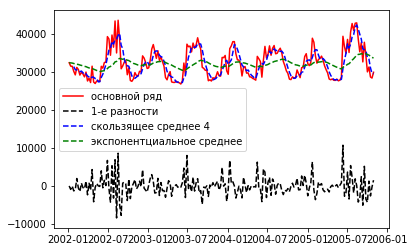

In [178]:
N100=200
plt.plot(data_w.index[:N100],data_w['PJME_MW'][:N100],'r',label ='основной ряд')
plt.plot(data_w.index[:N100],data_w['diff1'][:N100],'--k',label ='1-е разности')
plt.plot(data_w.index[:N100],data_w['w_m4'][:N100],'--b',label ='скользящее среднее 4')
plt.plot(data_w.index[:N100],data_w['exp_0_05'][:N100],'--g',label ='экспонентциальное среднее')
plt.legend()
plt.show()


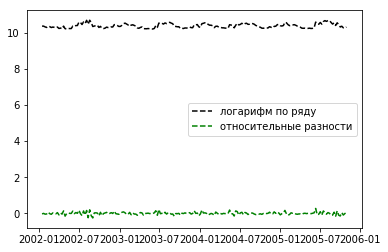

In [179]:
N100=200
plt.plot(data_w.index[1:N100],data_w['diff1_l'][1:N100],'--k',label ='логарифм по ряду')

plt.plot(data_w.index[1:N100],data_w['diff1_w'][1:N100],'--g',label ='относительные разности')
plt.legend()
plt.show()

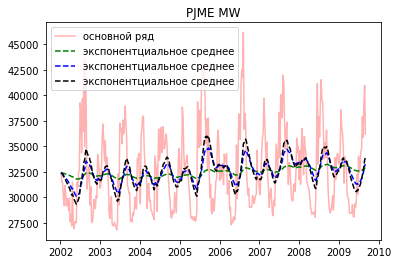

In [180]:
data_w['exp_0_01'] = exponential_smoothing(data_w['PJME_MW'], 0.01)
data_w['exp_0_03'] = exponential_smoothing(data_w['PJME_MW'], 0.03)
data_w['exp_0_04'] = exponential_smoothing(data_w['PJME_MW'], 0.04)
data_w['exp_0_06'] = exponential_smoothing(data_w['PJME_MW'], 0.06)
data_w['exp_0_07'] = exponential_smoothing(data_w['PJME_MW'], 0.07)
data_w['exp_0_08'] = exponential_smoothing(data_w['PJME_MW'], 0.08)

N100=400
plt.plot(data_w.index[:N100],data_w['PJME_MW'][:N100],'r',label ='основной ряд',alpha=0.3)
plt.plot(data_w.index[:N100],data_w['exp_0_01'][:N100],'--g',label ='экспонентциальное среднее')
plt.plot(data_w.index[:N100],data_w['exp_0_05'][:N100],'--b',label ='экспонентциальное среднее')
plt.plot(data_w.index[:N100],data_w['exp_0_08'][:N100],'--k',label ='экспонентциальное среднее')
plt.legend()
plt.title('PJME MW')
plt.show()

In [181]:
# Добавим истории длиной p в признаках автокорреляции. Возьмем квартал, 12 недель
p = 12
for i in range(p):
    data_w['t'+str(p-i)]=0
    data_w['t'+str(p-i)].values[p:] = data_w['PJME_MW'].values[i:-(p)+i]

In [182]:
# и разности тоже
p = 12
for i in range(p):
    data_w['d'+str(p-i)]=0
    data_w['d'+str(p-i)].values[p:] = data_w['diff1'].values[i:-(p)+i]

In [183]:
data_w.head()

,PJME_MW,month,quarter,weekofyear,is_holiday,is_prev_holiday,week_month,pca1,pca2,diff1,...,d10,d9,d8,d7,d6,d5,d4,d3,d2,d1
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0,0.160839,0.000000,0,-2.454496,2.612369,0.000000,...,0,0,0,0,0,0,0,0,0,0
2002-01-13,31487.386905,1.000000,1.0,2.0,0.000000,0.000000,1,-2.672075,-0.244236,-904.773926,...,0,0,0,0,0,0,0,0,0,0
2002-01-20,31452.880952,1.000000,1.0,3.0,0.000000,0.142857,1,-2.633792,-0.248124,-34.505951,...,0,0,0,0,0,0,0,0,0,0
2002-01-27,30141.529762,1.000000,1.0,4.0,0.142857,0.000000,0,-2.368253,2.281766,-1311.351196,...,0,0,0,0,0,0,0,0,0,0
2002-02-03,29196.488095,1.428571,1.0,5.0,0.000000,0.000000,1,-2.483988,-0.263194,-945.041687,...,0,0,0,0,0,0,0,0,0,0


In [184]:
scl_target=StandardScaler() 
# p = 12
h=1
target = data_w['PJME_MW'].values[h+p:].reshape((data_w.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(853, 1)

In [185]:
scl_x=StandardScaler() 

X = data_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(853, 44)

In [186]:
X[:4,12]=0

In [187]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)
for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))


F-test=0.97,  I=0
F-test=0.00,  I=1
F-test=0.00,  I=2
F-test=0.00,  I=3
F-test=0.00,  I=4
F-test=0.00,  I=5
F-test=0.00,  I=6
F-test=0.00,  I=7
F-test=0.00,  I=8
F-test=0.02,  I=9
F-test=0.02,  I=10
F-test=1.00,  I=11
F-test=0.57,  I=12
F-test=0.02,  I=13
F-test=0.01,  I=14
F-test=0.01,  I=15
F-test=0.02,  I=16
F-test=0.03,  I=17
F-test=0.04,  I=18
F-test=0.05,  I=19
F-test=0.29,  I=20
F-test=0.27,  I=21
F-test=0.19,  I=22
F-test=0.12,  I=23
F-test=0.06,  I=24
F-test=0.01,  I=25
F-test=0.00,  I=26
F-test=0.02,  I=27
F-test=0.07,  I=28
F-test=0.15,  I=29
F-test=0.30,  I=30
F-test=0.51,  I=31
F-test=0.00,  I=32
F-test=0.00,  I=33
F-test=0.01,  I=34
F-test=0.01,  I=35
F-test=0.02,  I=36
F-test=0.03,  I=37
F-test=0.04,  I=38
F-test=0.04,  I=39
F-test=0.04,  I=40
F-test=0.03,  I=41
F-test=0.02,  I=42
F-test=0.02,  I=43


In [188]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(853, 5)

In [189]:
column_names = data_w.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 'diff1_l', 'w_m4', 't2', 't1'], dtype='object')

In [190]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(853, 5)

In [191]:
column_namesp = data_w.columns[sfp.get_support()]
column_namesp

Index(['PJME_MW', 'diff1_l', 'w_m4', 't2', 't1'], dtype='object')

In [192]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(853, 5)

In [193]:
[X_new1[10:15,:], X_new2[10:15,:],X_new3[10:15,:]]

[array([[-0.28504649, -0.23543686, -0.76414287, -1.15215681, -0.16149726],
        [ 0.08561533,  0.14891672, -0.42382399, -0.15946616, -0.28332876],
        [ 0.11141115,  0.17500805, -0.06735334, -0.28130093,  0.08766944],
        [ 1.78909791,  1.7153962 ,  0.4820057 ,  0.0897072 ,  0.11343668],
        [ 1.63136583,  1.58226337,  1.02123423,  0.11547512,  1.79205969]]),
 array([[-0.28504649, -0.23543686, -0.76414287, -1.15215681, -0.16149726],
        [ 0.08561533,  0.14891672, -0.42382399, -0.15946616, -0.28332876],
        [ 0.11141115,  0.17500805, -0.06735334, -0.28130093,  0.08766944],
        [ 1.78909791,  1.7153962 ,  0.4820057 ,  0.0897072 ,  0.11343668],
        [ 1.63136583,  1.58226337,  1.02123423,  0.11547512,  1.79205969]]),
 array([[-0.28504649, -0.23543686, -0.85295638, -0.53540544, -1.22228529],
        [ 0.08561533,  0.14891672, -0.53769183, -1.12057993, -0.14346473],
        [ 0.11141115,  0.17500805, -1.12350611, -0.94166508, -1.18868186],
        [ 1.78909791,

In [194]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 11 12 30 31]
Номера признаков лучших признаков по процентной форме:  [ 0 11 12 30 31]
Номера признаков для выбора по модели :  [ 0 11 20 21 24]


In [195]:
list_par=[0,11,12, 20 ,21,24,30,31]
X_new = X[:,list_par]
data_w.columns[list_par]

Index(['PJME_MW', 'diff1_l', 'w_m4', 't12', 't11', 't8', 't2', 't1'], dtype='object')

### Формирование модери АРИМА

In [39]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

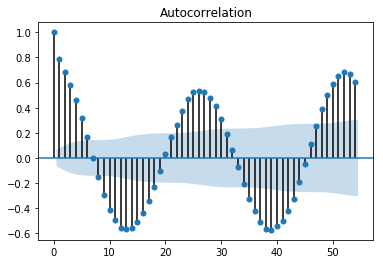

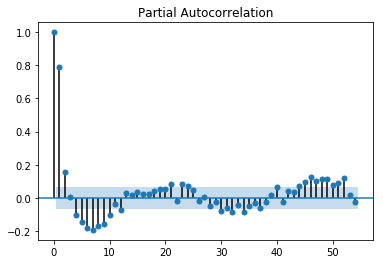

In [40]:
sm.graphics.tsa.plot_acf(data_w['PJME_MW'].values, lags=54)
plt.show()
sm.graphics.tsa.plot_pacf(data_w['PJME_MW'].values, lags=54)
plt.show()

In [41]:
import warnings
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q

p = [0] 
d = [0,1]
q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [42]:
warnings.filterwarnings("ignore") # отключает предупреждения
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_w['PJME_MW'].values[300:-30],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 52)3 - AIC:12624.295159952431
ARIMA(0, 0, 0)x(0, 0, 1, 52)3 - AIC:11068.3732383401
ARIMA(0, 0, 0)x(0, 0, 2, 52)3 - AIC:9806.343406681064
ARIMA(0, 0, 0)x(0, 1, 0, 52)3 - AIC:9100.734066398636
ARIMA(0, 0, 0)x(0, 1, 1, 52)3 - AIC:8077.8029882015935
ARIMA(0, 0, 0)x(0, 1, 2, 52)3 - AIC:7071.1531046526525
ARIMA(0, 0, 1)x(0, 0, 0, 52)3 - AIC:12222.359403009996
ARIMA(0, 0, 1)x(0, 0, 1, 52)3 - AIC:10949.346180851084
ARIMA(0, 0, 1)x(0, 0, 2, 52)3 - AIC:9753.54521133105
ARIMA(0, 0, 1)x(0, 1, 0, 52)3 - AIC:9024.342528152685
ARIMA(0, 0, 1)x(0, 1, 1, 52)3 - AIC:8008.242886563867
ARIMA(0, 0, 1)x(0, 1, 2, 52)3 - AIC:6992.181248857538
ARIMA(0, 0, 2)x(0, 0, 0, 52)3 - AIC:12107.39430953306
ARIMA(0, 0, 2)x(0, 0, 1, 52)3 - AIC:10901.71459593784
ARIMA(0, 0, 2)x(0, 0, 2, 52)3 - AIC:9719.451018633152
ARIMA(0, 0, 2)x(0, 1, 0, 52)3 - AIC:8997.733061900464
ARIMA(0, 0, 2)x(0, 1, 1, 52)3 - AIC:7977.063992785488
ARIMA(0, 0, 2)x(0, 1, 2, 52)3 - AIC:6962.031401472708
ARIMA(0, 1, 0)x(0, 0, 0, 

ARIMA(2, 2, 1)x(0, 0, 2, 52)3 - AIC:7921.926670812073
ARIMA(2, 2, 1)x(0, 1, 0, 52)3 - AIC:9112.37899008551
ARIMA(2, 2, 1)x(0, 1, 1, 52)3 - AIC:7921.657577123531
ARIMA(2, 2, 1)x(0, 1, 2, 52)3 - AIC:7029.354707100111
ARIMA(2, 2, 2)x(0, 0, 0, 52)3 - AIC:9833.52624267222
ARIMA(2, 2, 2)x(0, 0, 1, 52)3 - AIC:8854.612766775428
ARIMA(2, 2, 2)x(0, 0, 2, 52)3 - AIC:7899.4297943734355
ARIMA(2, 2, 2)x(0, 1, 0, 52)3 - AIC:9059.73945038456
ARIMA(2, 2, 2)x(0, 1, 1, 52)3 - AIC:7926.297968775887
ARIMA(2, 2, 2)x(0, 1, 2, 52)3 - AIC:6956.555040319863


In [44]:
data_w['PJME_MW'].values.shape

(866,)

In [51]:
# Используем ARIMA(1, 1, 2)x(0, 1, 2, 52)3 - AIC:6867.843227809823
# Предсказываем 4 точки
#для построения модели используем все данные, кроме 3-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения
N1 = 300   # берем дданные не от начала - так быстрее работает
N2 = 8  # число точек для теста 2*4 недели
nforecast = N2+4 # прогноз на 4 точки


    
mod = sm.tsa.statespace.SARIMAX(data_w['PJME_MW'].values[N1:-N2],order=[1,1,2],
                                seasonal_order=[0,1,2,52] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC: ',results_opt.aic)


AIC:{} 7309.1470091880965


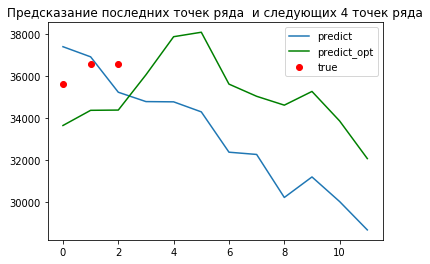

In [52]:
pred_dynamic = results.forecast(nforecast)
pred_dynamic_opt = results_opt.forecast(nforecast)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_w['PJME_MW'].values[-3:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 4 точек ряда')
plt.legend()

plt.show()

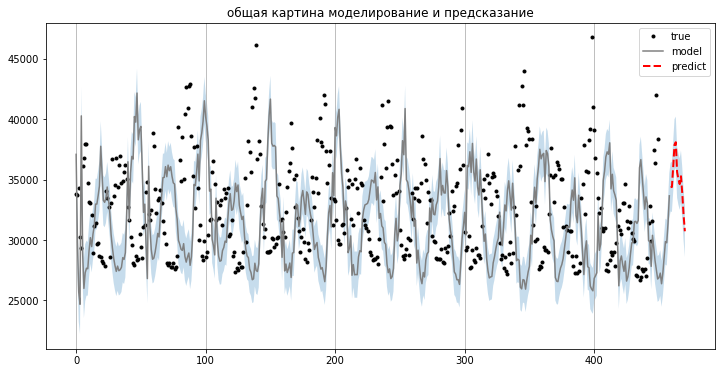

In [60]:
N3=100
predict_ = results_opt.get_prediction(end=results_opt.nobs + nforecast)  # делаем предсказание

# отображаем
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(data_w['PJME_MW'].values[N3:550], 'k.',label='true')

# 
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast], 'gray',label = 'model')
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2, label='predict')
ax.fill_between(idx, predict_ci[N3:, 0], predict_ci[N3:, 1], alpha=0.25)
plt.legend()
ax.set(title='общая картина моделирование и предсказание');

In [63]:
# Используем ARIMA(1, 1, 2)x(0, 1, 2, 52)3 - AIC:6867.843227809823
# Предсказываем 1 точку
#для построения модели используем все данные, кроме 3-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения
N1 = 300   # берем дданные не от начала - так быстрее работает
N2 = 8  # число точек для теста 2*4 недели
nforecast = N2+1 # прогноз на 1 точку

mod = sm.tsa.statespace.SARIMAX(data_w['PJME_MW'].values[N1:-N2],order=[1,1,2],
                                seasonal_order=[0,1,2,52] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)


AIC:{} 7309.1470091880965


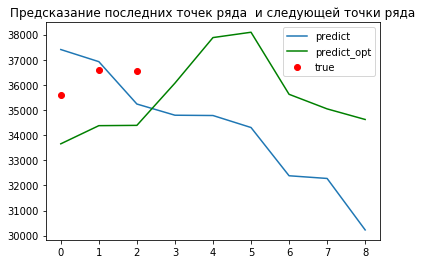

In [64]:
pred_dynamic = results.forecast(nforecast)
pred_dynamic_opt = results_opt.forecast(nforecast)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_w['PJME_MW'].values[-3:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующей точки ряда')
plt.legend()

plt.show()

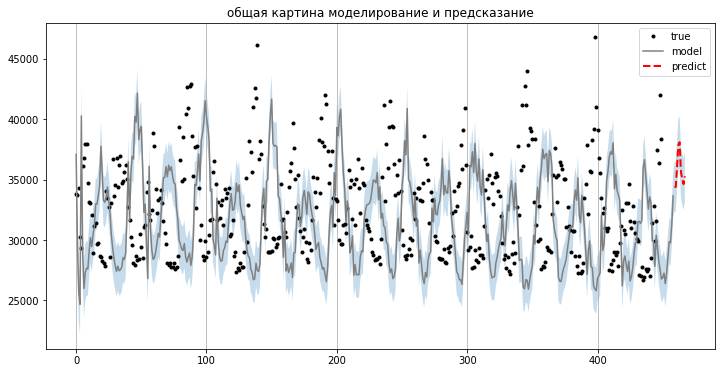

In [65]:
N3=100
predict_ = results_opt.get_prediction(end=results_opt.nobs + nforecast)  # делаем предсказание

# отображаем
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(data_w['PJME_MW'].values[N3:550], 'k.',label='true')

# 
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast], 'gray',label = 'model')
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2, label='predict')
ax.fill_between(idx, predict_ci[N3:, 0], predict_ci[N3:, 1], alpha=0.25)
plt.legend()
ax.set(title='общая картина моделирование и предсказание');

Вывод не получился... к сожалению

### Строим модель с авторекурсией

In [196]:
# функция разделения
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [197]:
data_w.iloc[800:810,:]


,PJME_MW,month,quarter,weekofyear,is_holiday,is_prev_holiday,week_month,pca1,pca2,diff1,...,d10,d9,d8,d7,d6,d5,d4,d3,d2,d1
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-07,26253.535714,5.000000,2.000000,18.0,0.000000,0.000000,2,-0.854224,-0.409788,-1072.303589,...,-3887,2776,208,2595,-3691,-1264,-1029,-1281,84,1693
2017-05-14,25652.815476,5.000000,2.000000,19.0,0.000000,0.000000,2,-0.815941,-0.413676,-600.720215,...,2776,208,2595,-3691,-1264,-1029,-1281,84,1693,-1072
2017-05-21,29925.625000,5.000000,2.000000,20.0,0.000000,0.000000,2,-0.777659,-0.417565,4272.809570,...,208,2595,-3691,-1264,-1029,-1281,84,1693,-1072,-600
2017-05-28,26196.125000,5.000000,2.000000,21.0,0.000000,0.142857,2,-0.739376,-0.421453,-3729.500000,...,2595,-3691,-1264,-1029,-1281,84,1693,-1072,-600,4272
2017-06-04,26974.898810,5.571429,2.000000,22.0,0.142857,0.000000,0,-0.376187,2.098713,778.773804,...,-3691,-1264,-1029,-1281,84,1693,-1072,-600,4272,-3729
2017-06-11,28988.595238,6.000000,2.000000,23.0,0.000000,0.000000,2,-0.491921,-0.446247,2013.696411,...,-1264,-1029,-1281,84,1693,-1072,-600,4272,-3729,778
2017-06-18,36366.410714,6.000000,2.000000,24.0,0.000000,0.000000,2,-0.453639,-0.450136,7377.815430,...,-1029,-1281,84,1693,-1072,-600,4272,-3729,778,2013
2017-06-25,36119.327381,6.000000,2.000000,25.0,0.000000,0.000000,2,-0.415356,-0.454024,-247.083328,...,-1281,84,1693,-1072,-600,4272,-3729,778,2013,7377
2017-07-02,34042.714286,6.285714,2.285714,26.0,0.000000,0.000000,2,-0.179170,-0.472851,-2076.613037,...,84,1693,-1072,-600,4272,-3729,778,2013,7377,-247


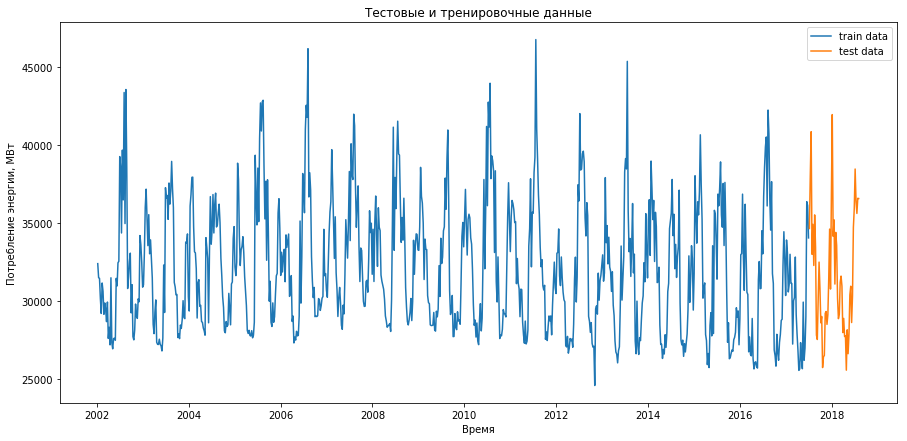

In [198]:
train, test = split_data( data_w, '07-05-2017')


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [199]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [200]:
train.shape

(809, 44)

In [201]:
from sklearn.ensemble import GradientBoostingRegressor

In [202]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

In [203]:
model_g.fit( X_train, y_train )

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [204]:
y_test_pred_g = model_g.predict(X_test)

In [208]:
h = 1
p = 12
test.index[h+p:].shape

(44,)

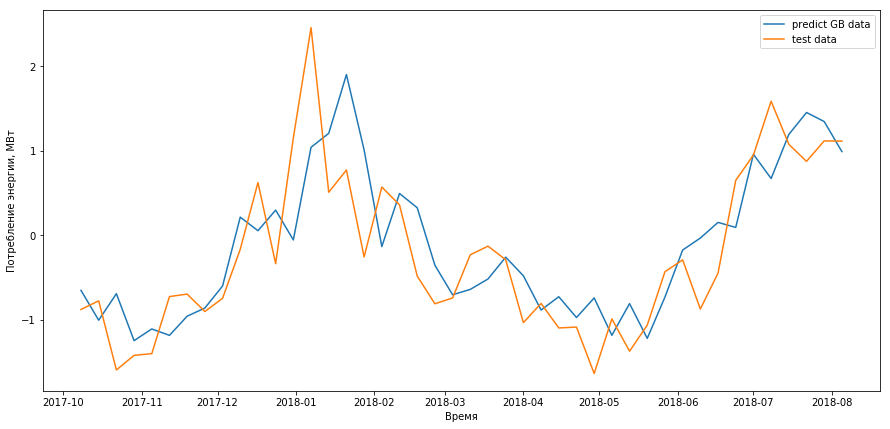

In [209]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

In [210]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [211]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.3441781955240969 
ошибка mae  :   0.46214302228116555 
оценка R2 :   0.6143219737239467


In [212]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [213]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   5.860404689240631 %


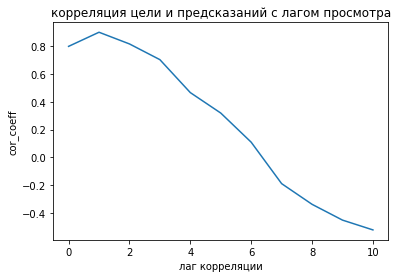

In [214]:
lag=10
p_cor=[np.corrcoef( y_test, y_test_pred_g)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция цели и предсказаний с лагом просмотра')
plt.show()

In [215]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,10,14,5, 20, 7, 15, 18, 25], 
              "n_estimators":[50, 100,200,300,350, 400,500, 700, 800, 1000, 1200,1500, 1800]}

#  randomized search
n_iter_search = 30

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.651 (std: 0.059)
Parameters: {'n_estimators': 50, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.621 (std: 0.077)
Parameters: {'n_estimators': 50, 'max_depth': 5}

Model with rank: 3
Mean validation score: 0.599 (std: 0.066)
Parameters: {'n_estimators': 400, 'max_depth': 2}



In [227]:
model_g_best = GradientBoostingRegressor(max_depth=2,  n_estimators=50)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   5.692101582263868 %


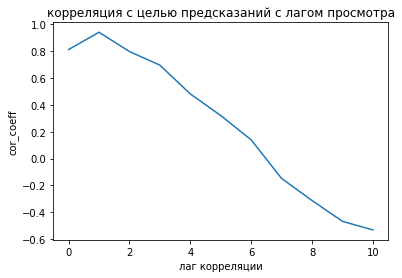

In [228]:
lag=10
p_cor=[np.corrcoef( y_test, y_test_pred_g)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

Победить 1 значение не удалось... 

In [229]:
import pickle
# save the model1 to disk
filename = 'final_model1.sav'
pickle.dump(model_g_best, open(filename, 'wb'))

filename = 'final_scaler_y1.sav'
pickle.dump(scl_target, open(filename, 'wb'))

filename = 'final_scaler_x1.sav'
pickle.dump(scl_x, open(filename, 'wb'))


In [241]:
X_test_100[i+1,7]

1.120104667441103

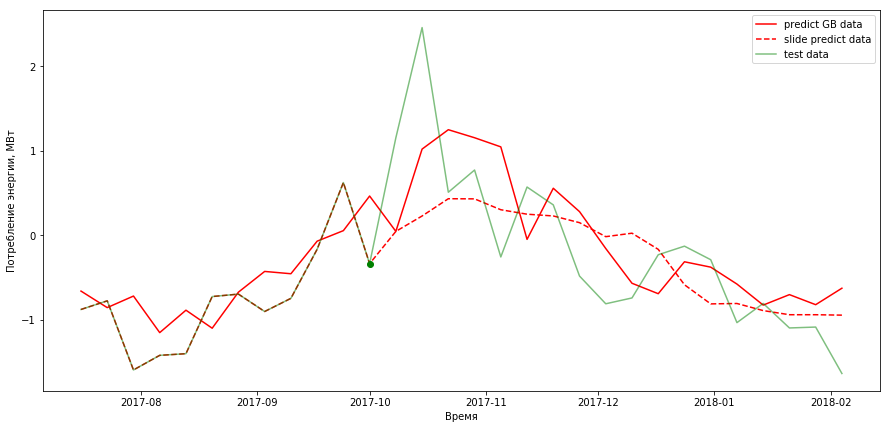

In [242]:
# 'PJME_MW', 'diff1_l', 'w_m4', 't2', 't1'
# 'PJME_MW', 'diff1_l', 'w_m4', 't2', 't1'
#'PJME_MW', 'diff1_l', 'w_m4', 't12', 't11', 't8', 't2', 't1'
 
X_test_100 = X_test.copy()
y_test_100 = y_test.copy()
N10 = 30
for i in range(p,N10+p):
    y_test_100[i] = model_g_best.predict(X_test_100[i,:].reshape((1,X_test_100.shape[1])))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1]  )
                                     
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]

    #строим 'w_m4' - признак под номером 3
    X_test_100[i+1,2] = np.mean(X_test_100[i-6:i+1,0]) 
    # строим логарифм по значению ряда и скалируем признак по схеме 15-го признака из основного списка
    xy_i=(np.log((y_i))-scl_x.mean_[15])*scl_x.scale_[15]
    #устанавливаем новое значение для 1
    X_test_100[i+1,1] = xy_i 
    # обновим историю значенний
    X_test_100[i+1,3] = X_test_100[i-12,0]
    X_test_100[i+1,4] = X_test_100[i-11,0]
    X_test_100[i+1,5] = X_test_100[i-8,0]
    X_test_100[i+1,6] = X_test_100[i-2,0]
    X_test_100[i+1,7] = X_test_100[i-1,0]
        
    
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[p],y_test[p-1], 'og', alpha=1)
plt.legend()
plt.show()    

In [243]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[p:N10]),y_pred = scl_target.inverse_transform( y_test_100[p:N10]))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   6.30848878672886 %


In [ ]:
Вывод: Мне кажется, что результат рекурсивного моделирования выглядит симпатичнее :) 

К сожалению, задание "Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)" не совсем понял... Судя по графику выше ошибка не должна сильно меняться. Предикт и тест следуют друг за другом.